In [ ]:
# 1. Install Library (kalau belum)
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow nltk wordcloud textblob transformers --quiet


In [ ]:
# 2. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import pipeline


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 3. Load Dataset
df = pd.read_csv('/content/threads_reviews.csv')
df.dropna(subset=['review_description'], inplace=True)

<ipython-input-5-595e3fa649c2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='Set2')


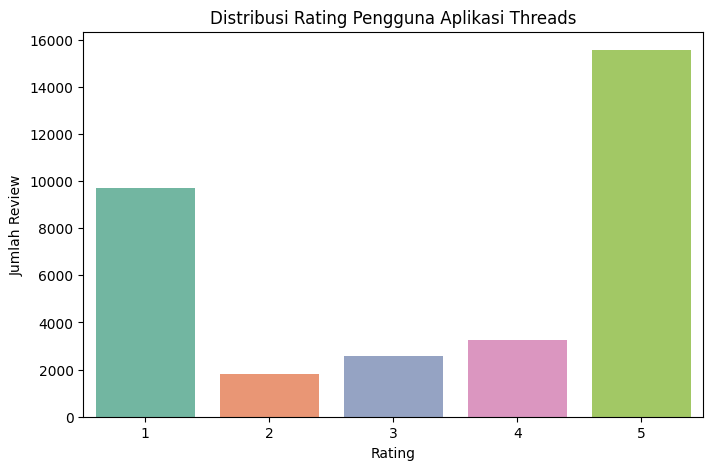

In [ ]:
# 4. Distribusi Rating Pengguna Aplikasi Threads
if 'rating' in df.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(x='rating', data=df, palette='Set2')
    plt.title("Distribusi Rating Pengguna Aplikasi Threads")
    plt.xlabel("Rating")
    plt.ylabel("Jumlah Review")
    plt.show()
else:
    print("Kolom 'rating' tidak tersedia dalam dataset.")

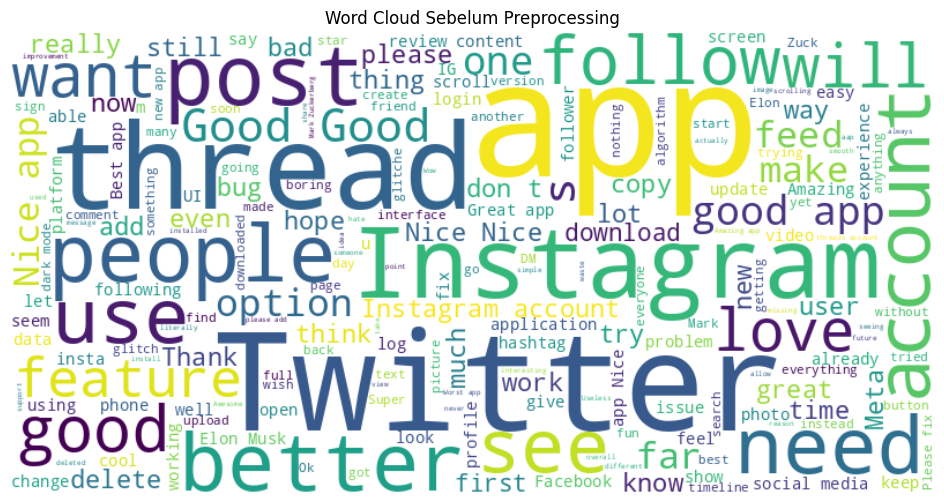

In [ ]:
# 5. Word Cloud Sebelum Preprocessing
text_all = " ".join(df['review_description'].astype(str))
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(text_all)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Sebelum Preprocessing")
plt.show()

In [ ]:
# 6. Preprocessing untuk Bahasa Inggris
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text_en(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['review_description'].apply(clean_text_en)

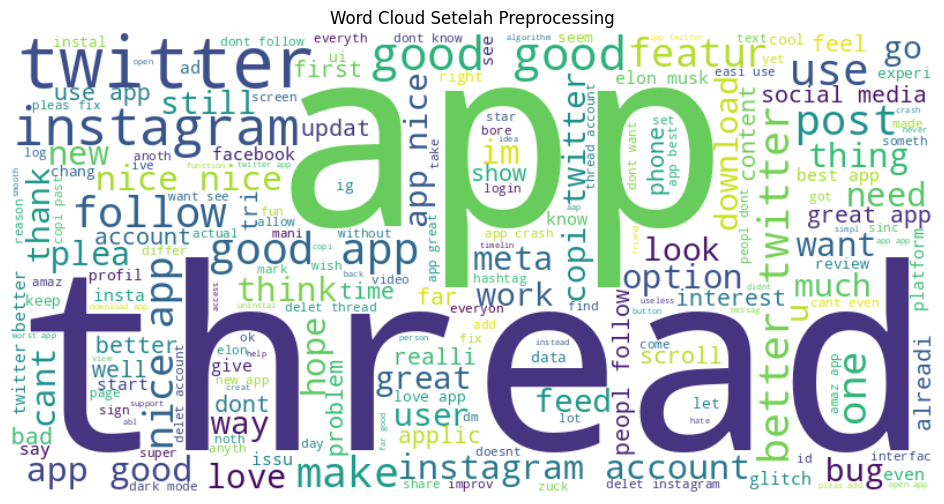

In [ ]:
# 7. Word Cloud Setelah Preprocessing
text_cleaned = " ".join(df['cleaned'].astype(str))
wordcloud_after = WordCloud(width=800, height=400, background_color='white').generate(text_cleaned)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_after, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Setelah Preprocessing")
plt.show()

In [ ]:
# 8. Sentiment Analysis menggunakan BERT
sentiment_pipeline = pipeline("sentiment-analysis")

def bert_sentiment_chunked(text, chunk_size=512):
    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    sentiments = []

    for chunk in chunks:
        result = sentiment_pipeline(chunk)[0]
        sentiments.append(result['label'])

    if sentiments.count('POSITIVE') > sentiments.count('NEGATIVE'):
        return 'positif'
    elif sentiments.count('NEGATIVE') > sentiments.count('POSITIVE'):
        return 'negatif'
    else:
        return 'netral'

bert_labels = []
for review in df['review_description']:
    label = bert_sentiment_chunked(str(review))
    bert_labels.append(label)

df['sentiment'] = bert_labels

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


<ipython-input-10-1c5b9a48468e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='pastel', order=['positif', 'netral', 'negatif'])


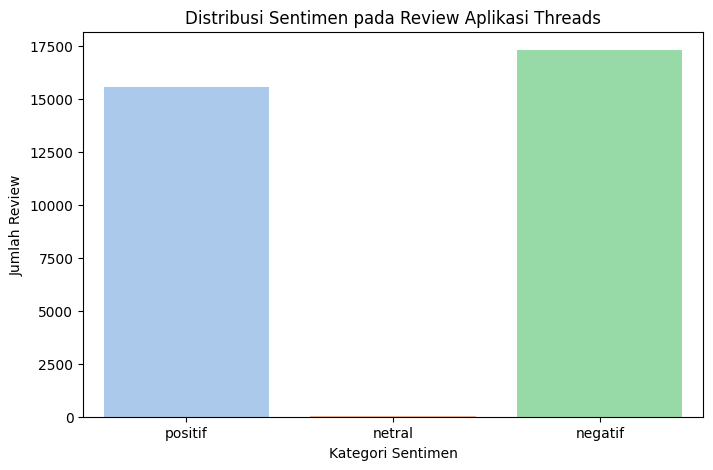

In [ ]:
# 🔥 Tambahan Visualisasi Hasil Label Sentimen
plt.figure(figsize=(8,5))
sns.countplot(x='sentiment', data=df, palette='pastel', order=['positif', 'netral', 'negatif'])
plt.title("Distribusi Sentimen pada Review Aplikasi Threads")
plt.xlabel("Kategori Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

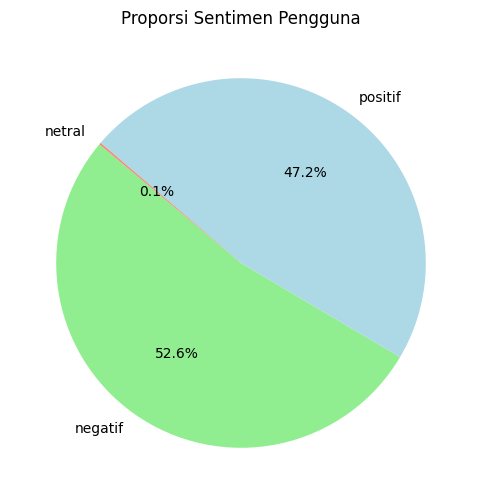

In [ ]:
# 🔥 Pie Chart Sentimen
plt.figure(figsize=(6,6))
colors = ['lightgreen', 'lightblue', 'salmon']
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proporsi Sentimen Pengguna')
plt.ylabel('')
plt.show()

In [ ]:
# 9. Encode Label Sentimen
sentiment_map = {'negatif': 0, 'netral': 1, 'positif': 2}
df['label'] = df['sentiment'].map(sentiment_map)



In [ ]:
# 10. Tokenisasi dan Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned'])
sequences = tokenizer.texts_to_sequences(df['cleaned'])

maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)
y = pd.get_dummies(df['label']).values

In [ ]:
# 11. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# 12. Model LSTM
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=maxlen),
    LSTM(128),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - accuracy: 0.7131 - loss: 0.5631 - val_accuracy: 0.8621 - val_loss: 0.3328
Epoch 2/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 141s 227ms/step - accuracy: 0.8905 - loss: 0.2872 - val_accuracy: 0.8656 - val_loss: 0.3262
Epoch 3/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 139s 218ms/step - accuracy: 0.9151 - loss: 0.2359 - val_accuracy: 0.8656 - val_loss: 0.3364
Epoch 4/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.9276 - loss: 0.2058 - val_accuracy: 0.8568 - val_loss: 0.3532
Epoch 5/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 143s 226ms/step - accuracy: 0.9327 - loss: 0.1903 - val_accuracy: 0.8496 - val_loss: 0.3714


In [ ]:
# 13. Evaluasi Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi Model: {accuracy*100:.2f}%")

206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8477 - loss: 0.4049
Akurasi Model: 84.53%


206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step


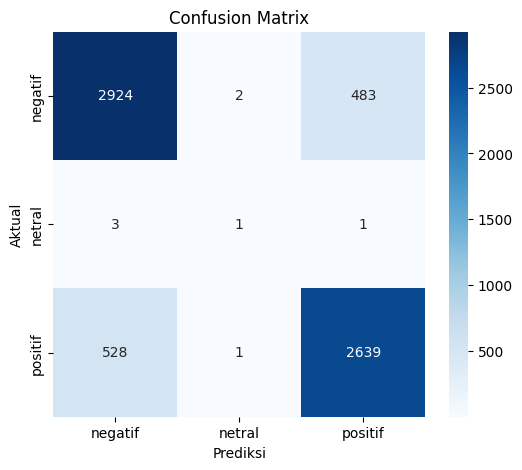

              precision    recall  f1-score   support

     negatif       0.85      0.86      0.85      3409
      netral       0.25      0.20      0.22         5
     positif       0.85      0.83      0.84      3168

    accuracy                           0.85      6582
   macro avg       0.65      0.63      0.64      6582
weighted avg       0.85      0.85      0.85      6582



In [ ]:
# 14. Confusion Matrix & Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sentiment_map.keys(),
            yticklabels=sentiment_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=list(sentiment_map.keys())))

In [ ]:
# 15. Tampilkan Contoh Komentar per Kategori Sentimen
print("\nContoh Komentar Positif:")
print(df[df['sentiment'] == 'positif']['review_description'].iloc[0])

print("\nContoh Komentar Negatif:")
print(df[df['sentiment'] == 'negatif']['review_description'].iloc[0])

print("\nContoh Komentar Netral:")
print(df[df['sentiment'] == 'netral']['review_description'].iloc[0])


Contoh Komentar Positif:
Pretty good for a first launch!! Its easy to use and self-explanatory and I'd say the algorithm is good as well. It has great *potential* but a few things need improvement: -the ability to use hashtags would make it easier to find topics and people you'd be interested in -an option for a following-only feed would be a major improvement (especially chronological order) -the ability to choose images from albums rather than recent photos -the ability to save photos to phone

Contoh Komentar Negatif:
Meh. Not the greatest experience on a Chromebook. Seems to be customized for phones only. Opens in a little screen that you can't expand or resize - for reasons that are a complete mystery to me. Judging from the fact that every other app I know of is resizeable, this seems like it was a conscious choice by the developers . Why you'd do something like this is beyond understanding and suggests a control freak approach. Not a great way to make a first impression.

Conto

In [ ]:
# 16. Tambahan: Cek 5 Kalimat Acak untuk Analisis Kontekstual
import random

print("\n\n=== Cek 5 Review Acak Berdasarkan Makna Kalimat (oleh BERT) ===\n")
sample_reviews = df['review_description'].dropna().sample(5, random_state=42)

for i, review in enumerate(sample_reviews):
    result = sentiment_pipeline(str(review))[0]
    print(f"Review {i+1}: {review}")
    print(f"> Deteksi Sentimen: {result['label']} (Confidence: {result['score']:.2f})")
    print("-" * 80)



=== Cek 5 Review Acak Berdasarkan Makna Kalimat (oleh BERT) ===

Review 1: Glitch
> Deteksi Sentimen: NEGATIVE (Confidence: 1.00)
--------------------------------------------------------------------------------
Review 2: Display rendering issue where text overlays on top of everything when scrolling or opening menu makes app completely unsustainable.
> Deteksi Sentimen: NEGATIVE (Confidence: 1.00)
--------------------------------------------------------------------------------
Review 3: 😌❤
> Deteksi Sentimen: NEGATIVE (Confidence: 0.70)
--------------------------------------------------------------------------------
Review 4: Worst, Just copy and paste instagram code to threads 😂🤣🤣🤣
> Deteksi Sentimen: NEGATIVE (Confidence: 1.00)
--------------------------------------------------------------------------------
Review 5: ممل
> Deteksi Sentimen: POSITIVE (Confidence: 0.89)
--------------------------------------------------------------------------------
